In [ ]:
#install the required library
!pip install gymnasium>=1.0.0
!pip install kaggle-environments
!pip install pygame

# Agent trained by SARSA(λ) with fixed exploration rate(0.1)

#### Import libraries

In [2]:
#import the necessary libraries
import numpy as np
import random
from collections import defaultdict
from kaggle_environments import make,evaluate
import matplotlib.pyplot as plt
import pickle

#### Define SARSA(λ) Class

In [3]:

class SARSA_lambda:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1, lambda_=0.9):
        self.env = env
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.lambda_ = lambda_  # Eligibility trace decay rate

        self.rows = env.configuration["rows"]
        self.columns = env.configuration["columns"]
        self.action_size = env.configuration["columns"]  # Number of possible actions

        # Use dictionary for Q-table and eligibility traces
        self.q_table = defaultdict(lambda: np.zeros(self.action_size))
        self.e_table = defaultdict(lambda: np.zeros(self.action_size))

    def get_state(self, obs):
        """Convert board to tuple (hashable for dict storage)."""
        return tuple(obs.board)

    def choose_action(self, obs):
        """Epsilon-greedy action selection."""
        state = self.get_state(obs)
        valid_moves = [c for c in range(self.columns) if obs.board[c] == 0]

        if random.uniform(0, 1) < self.epsilon:
            return random.choice(valid_moves)  # Random action
        else:
            q_values = [self.q_table[state][a] for a in valid_moves]
            return valid_moves[np.argmax(q_values)]  # Best valid action

    def update(self, state, action, reward, next_state, next_action):
        """SARSA(λ) update rule with sparse table."""
        td_error = reward + self.gamma * self.q_table[next_state][next_action] - self.q_table[state][action]
        self.e_table[state][action] += 1  # Update eligibility trace

        # Update Q-values and decay traces
        for s in self.q_table:
            self.q_table[s] += self.alpha * td_error * self.e_table[s]
            self.e_table[s] *= self.gamma * self.lambda_

    def reset(self):
        """Reset eligibility traces."""
        self.e_table.clear()

    # Save Function
    def save_q_table(self, filename="sarsa_lambda_q_table.pkl"):
        """Save Q-table to a file."""
        with open(filename, "wb") as f:
            pickle.dump(dict(self.q_table), f)  # Convert defaultdict to normal dict
        print(f"Q-table saved to {filename}")

    # Load Function
    def load_q_table(self, filename="sarsa_lambda_q_table.pkl"):
        """Load Q-table from a file."""
        try:
            with open(filename, "rb") as f:
                loaded_q_table = pickle.load(f)
                self.q_table = defaultdict(lambda: np.zeros(self.action_size), loaded_q_table)
            print(f"Q-table loaded from {filename}")
        except FileNotFoundError:
            print(f"File {filename} not found. Starting with an empty Q-table.")  # Handling if file is missing


#### Define the Train function

In [4]:
# Training SARSA(λ)
def train_sarsa_lambda(env, agent, episodes, save_file="sarsa_lambda_q_table.pkl"):
    trainer = env.train([None, "random"])
    rewards = []
    wins, losses, draws = 0, 0, 0  # Track game outcomes

    # Load Q-table 
    agent.load_q_table(save_file)  

    for episode in range(1, episodes + 1):
        obs = trainer.reset()
        state = agent.get_state(obs)
        action = agent.choose_action(obs)
        agent.reset()  # Reset eligibility traces

        done = False
        total_reward = 0

        while not done:
            new_obs, reward, done, _ = trainer.step(action)
            new_state = agent.get_state(new_obs)

            # Choose next action if game is not over
            new_action = agent.choose_action(new_obs) if not done else None

            # Update Q-table using SARSA(λ)
            agent.update(state, action, reward, new_state, new_action if new_action is not None else 0)

            # Move to the next state
            state, action = new_state, new_action
            total_reward += reward

        # Track rewards
        rewards.append(total_reward)

        # Track game outcomes
        if reward == 1:
            wins += 1
        elif reward == -1:
            losses += 1
        else:
            draws += 1

        # Print progress every 100 episodes
        if episode % 100 == 0:
            win_rate = wins / max(1, episode)
            avg_reward = np.mean(rewards[-100:])  # Average reward over the last 100 episodes
            print(f"Episode {episode}:  Win Rate: {win_rate:.2f}: Avg Reward: {avg_reward:.2f}")

    # Save the Q-table after training
    agent.save_q_table(save_file)
    print(f"\nTraining completed. Q-table saved to {save_file}")

    return rewards  # Return collected rewards


#### Define the Evaluation function

In [5]:

# Evaluate SARSA(λ) Agent
def evaluate_agent(env, agent, episodes, interval=10):
    trainer = env.train([None, "random"])

    # Load Q-table for evaluation 
    agent.load_q_table("sarsa_lambda_q_table.pkl")
    # Set exploration rate to 0 for evaluation (no exploration, only exploitation)
    agent.epsilon = 0
    # Metrics Initialization
    wins, losses, draws = 0, 0, 0
    total_rewards = []
    win_rates = []
    reward_variances = []

    for episode in range(1, episodes + 1):
        obs = trainer.reset()
        done = False
        episode_rewards = 0  # Track cumulative reward per episode

        while not done:
            action = agent.choose_action(obs)
            obs, reward, done, _ = trainer.step(action)
            episode_rewards += reward  # Accumulate episode reward

        total_rewards.append(episode_rewards)  # Store total reward

        # Determine match outcome
        if reward == 1:
            wins += 1
        elif reward == -1:
            losses += 1
        else:
            draws += 1

        # Store win rate and other metrics at intervals
        if episode % interval == 0:
            win_rate = wins / max(1, (wins + losses + draws))
            avg_reward = np.mean(total_rewards[-interval:])  # Average reward over last interval
            reward_variance = np.var(total_rewards[-interval:])  # Variance in rewards

            win_rates.append(win_rate)
            reward_variances.append(reward_variance)

            print(f"After {episode} episodes: "
                  f"Win Rate: {win_rate:.2f}, "
                  f"Avg Reward: {avg_reward:.2f}, "
                  f"Reward Variance: {reward_variance:.2f}")

    print(f"\nFinal Results after {episodes} games:")
    print(f"Wins: {wins}, Losses: {losses}, Draws: {draws}, Win Rate: {wins / max(1, episodes):.2f}")

    return {
        "win_rates": win_rates,
        "total_rewards": total_rewards,
        "reward_variance": reward_variances
    }


#### Train and Evaluate the Agent

In [6]:
# Create environment
env = make("connectx", {"rows": 4, "columns": 5, "inarow": 3}, steps=[], debug=True)

# Initialize SARSA(λ) agent
sarsa_agent = SARSA_lambda(env)

# Train SARSA(λ) agent
rewards = train_sarsa_lambda(env, sarsa_agent, episodes=5000)  

# Evaluate trained SARSA(λ) agent
results = evaluate_agent(env, sarsa_agent, episodes=500, interval=10)

# Access metrics
win_rates = results["win_rates"]
total_rewards = results["total_rewards"]
reward_variance = results["reward_variance"]


Q-table loaded from sarsa_lambda_q_table.pkl
Episode 100:  Win Rate: 0.92: Avg Reward: 0.84
Episode 200:  Win Rate: 0.93: Avg Reward: 0.86
Episode 300:  Win Rate: 0.92: Avg Reward: 0.84
Episode 400:  Win Rate: 0.92: Avg Reward: 0.84
Episode 500:  Win Rate: 0.93: Avg Reward: 0.88
Episode 600:  Win Rate: 0.93: Avg Reward: 0.84
Episode 700:  Win Rate: 0.92: Avg Reward: 0.80
Episode 800:  Win Rate: 0.92: Avg Reward: 0.82
Episode 900:  Win Rate: 0.92: Avg Reward: 0.84
Episode 1000:  Win Rate: 0.91: Avg Reward: 0.72
Episode 1100:  Win Rate: 0.91: Avg Reward: 0.84
Episode 1200:  Win Rate: 0.92: Avg Reward: 0.92
Episode 1300:  Win Rate: 0.92: Avg Reward: 0.82
Episode 1400:  Win Rate: 0.92: Avg Reward: 0.86
Episode 1500:  Win Rate: 0.92: Avg Reward: 0.86
Episode 1600:  Win Rate: 0.92: Avg Reward: 0.88
Episode 1700:  Win Rate: 0.92: Avg Reward: 0.88
Episode 1800:  Win Rate: 0.92: Avg Reward: 0.86
Episode 1900:  Win Rate: 0.92: Avg Reward: 0.90
Episode 2000:  Win Rate: 0.92: Avg Reward: 0.80
Epis

#### Visualize the performance of the agent

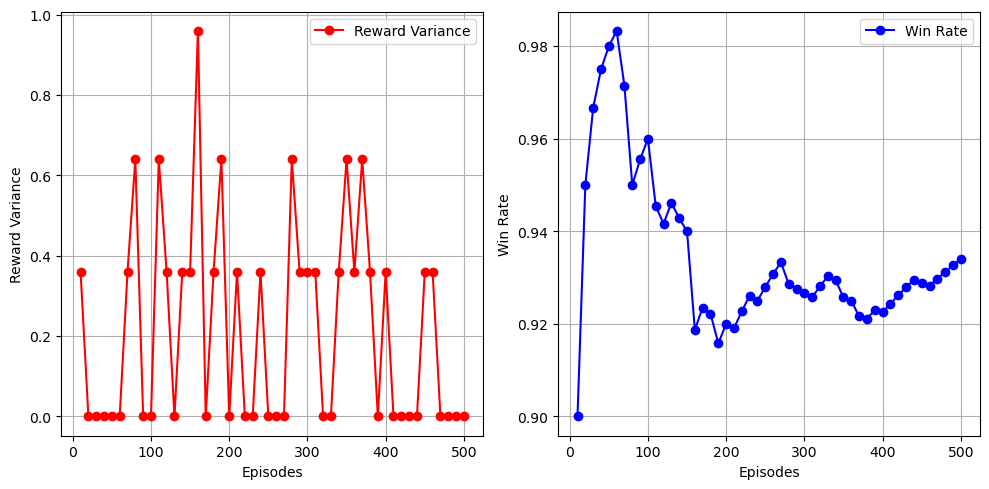

In [7]:

plt.figure(figsize=(10, 5))

# Plot reward variance
plt.subplot(1, 2, 1) 
plt.plot(range(10, 501, 10), results["reward_variance"], marker="o", linestyle="-", color="r", label="Reward Variance")
plt.xlabel("Episodes")
plt.ylabel("Reward Variance")
#plt.title("Reward Variance Over Time")
plt.legend()
plt.grid()

# Plot win rates
plt.subplot(1, 2, 2)
plt.plot(range(10, 501, 10), win_rates, marker="o", linestyle="-", color="b", label="Win Rate")
plt.xlabel("Episodes")
plt.ylabel("Win Rate")
#plt.title("Win Rate Over Time")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


### Test the Agent

#### 1. Play With Random

In [ ]:
# Load Q-table for evaluation 
sarsa_agent.load_q_table("sarsa_lambda_q_table.pkl")
# Function wrapper to get actions from SARSA agent
def sarsa_agent_function(obs):
    return sarsa_agent.choose_action(obs)
# Disable exploration during evaluation (ensure pure policy use)
sarsa_agent.epsilon = 0
# Initialize the game stats
wins, losses, draws = 0, 0, 0

# Train SARSA(λ) as Player 1 against random
trainer = env.train([None, "random"])

num_games = 40  
for game in range(num_games):
    obs = trainer.reset()
    done = False

    while not done:  # Keep playing until the game ends
        action = sarsa_agent_function(obs)
        obs, reward, done, info = trainer.step(action)

    # After the game ends, check the result and print the outcome
    if reward == 1:
        wins += 1
        print(f"Game {game + 1} Over! Player 1 (SARSA) won!")
    elif reward == -1:
        losses += 1
        print(f"Game {game + 1} Over! Player 1 (SARSA) lost!")
    else:
        draws += 1
        print(f"Game {game + 1} Over! It's a draw!")

    # Render the game after each game to visually check the board
    env.render(mode='ipython')

# Print summary after all games
print(f"\nSummary after {num_games} games:")
print(f"Wins: {wins}")
print(f"Losses: {losses}")
print(f"Draws: {draws}")


#### 2. Played with negamax

In [ ]:
# Load Q-table for evaluation 
sarsa_agent.load_q_table("sarsa_lambda_q_table.pkl")
# Function wrapper to get actions from SARSA agent
def sarsa_agent_function(obs):
    return sarsa_agent.choose_action(obs)
# Disable exploration during evaluation (ensure pure policy use)
sarsa_agent.epsilon = 0
# Initialize the game stats
wins, losses, draws = 0, 0, 0

# Train SARSA(λ) as Player 1 against negamax
trainer = env.train([None, "negamax"])

num_games = 40  
for game in range(num_games):
    obs = trainer.reset()
    done = False

    while not done:  # Keep playing until the game ends
        action = sarsa_agent_function(obs)
        obs, reward, done, info = trainer.step(action)

    # After the game ends, check the result and print the outcome
    if reward == 1:
        wins += 1
        print(f"Game {game + 1} Over! Player 1 (SARSA) won!")
    elif reward == -1:
        losses += 1
        print(f"Game {game + 1} Over! Player 1 (SARSA) lost!")
    else:
        draws += 1
        print(f"Game {game + 1} Over! It's a draw!")

    # Render the game after each game to visually check the board
    env.render(mode='ipython')

# Print summary after all games
print(f"\nSummary after {num_games} games:")
print(f"Wins: {wins}")
print(f"Losses: {losses}")
print(f"Draws: {draws}")
